In [34]:
%matplotlib inline

In [35]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

# jax.config.update("jax_enable_x64", True)

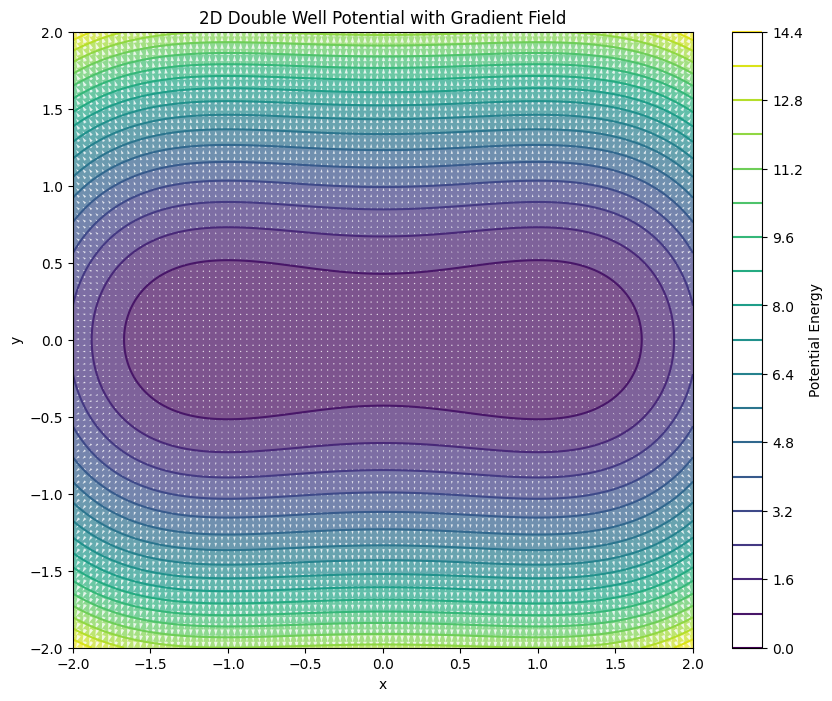

In [36]:

N = 500
# Create a 2D grid
lim = 2
x = jnp.linspace(-lim, lim, N)
y = jnp.linspace(-lim, lim, N)
X, Y = jnp.meshgrid(x, y)
grid_flat = jnp.stack([X.flatten(), Y.flatten()], axis=1)
def V(x):
    return 0.25 * (x[0]**2 - 1)**2 + 3 * x[1]**2

# lim = 45
# x = jnp.linspace(-lim, lim, N)
# y = jnp.linspace(-lim, lim, N)
# X, Y = jnp.meshgrid(x, y)
# grid_flat = jnp.stack([X.flatten(), Y.flatten()], axis=1)
# def V(x):
#     # Compute squared Mahalanobis distances for all components
#     diff = x - centers
#     inv_vars = jnp.linalg.inv(variances)
#     mahalanobis = jnp.einsum('ni, nij, nj -> n', diff, inv_vars, diff)
#     norm = jnp.sqrt((2 * jnp.pi)**2 * jnp.linalg.det(variances))
    
#     # Compute Gaussian mixture (negative since we want wells, not peaks)
#     # return -jnp.log( jnp.sum(jnp.exp(-0.5 * mahalanobis)) / len(centers))
#     return - jax.scipy.special.logsumexp(-0.5 * mahalanobis, b= 1/norm[0]) - jnp.log(len(centers))


V_vmap = jax.vmap(V)
V_vmap = jax.jit(V_vmap)
V = jax.jit(V)

# Calculate gradient using JAX for a single point
grad_V = lambda x: jax.grad(V)(x)
grad_V_vmap = jax.vmap(grad_V)
grad_V_vmap = jax.jit(grad_V_vmap)
grad_V = jax.jit(grad_V)


# Calculate the potential values
Z = V_vmap(grid_flat).reshape(N, N)

# Calculate gradients
V_grad = grad_V_vmap(grid_flat).reshape(N, N, 2)


# Create the plot
plt.close()
plt.figure(figsize=(10, 8))
# Create a contour plot
plt.contour(X, Y, Z, levels=20)
plt.colorbar(label='Potential Energy')

# Add filled contours for better visualization
plt.contourf(X, Y, Z, levels=20, alpha=0.7)

# Add gradient field (using fewer points for clarity)
skip = 5  # Plot every 5th point for clearer visualization
plt.quiver(X[::skip, ::skip], Y[::skip, ::skip], 
          V_grad[::skip, ::skip, 0], V_grad[::skip, ::skip, 1],
          color='white', alpha=0.8)

plt.xlabel('x')
plt.ylabel('y')
plt.title('2D Double Well Potential with Gradient Field')
plt.show()

In [37]:
V_hess = jax.hessian(V)
V_hess_vmap = jax.vmap(V_hess)
V_hess_vmap = jax.jit(V_hess_vmap)
V_hess = jax.jit(V_hess)

V_hess_flat = V_hess_vmap(grid_flat).reshape(N, N, 2, 2)



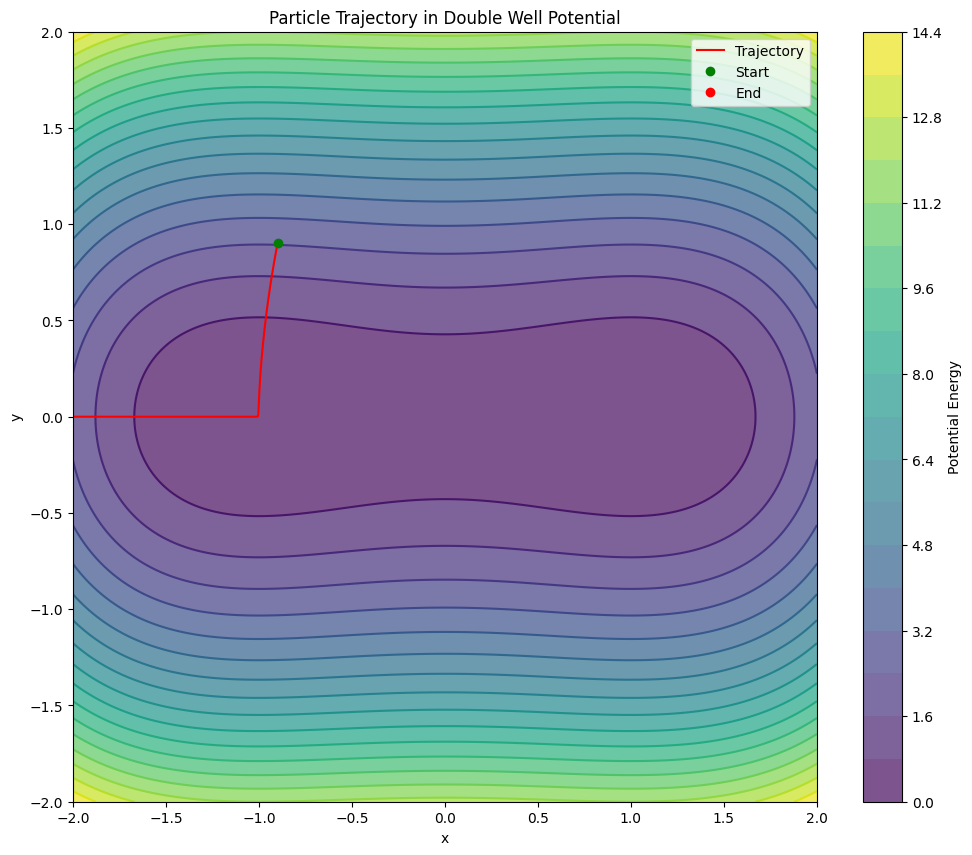

In [38]:
def v_dot_fn(x, v):
    # Calculate Hessian
    H_x = V_hess(x)

    # Calculate v' terms
    Hv = H_x @ v
    vHv = jnp.dot(v, Hv)

    return -Hv + vHv * v / jnp.dot(v, v)

def x_dot_fn(x, v):
    grad_x = grad_V(x)
    return -grad_x + 2 * jnp.dot(grad_x, v) * v / jnp.dot(v, v)

# Define the dynamics
def dynamics(state):
    x, v = state[:2], state[2:]
    
    
    x_dot = x_dot_fn(x, v)
    
    # Calculate v' = -Hv + vHv * v
    v_dot = v_dot_fn(x, v)
    
    return jnp.array([x_dot[0], x_dot[1], v_dot[0], v_dot[1]])

dynamics = jax.jit(dynamics)

# Set up integration
dt = 0.01
T = 600
times = jnp.arange(T) * dt

# Initial conditions
initial_direction = jnp.array([-0.9, 0.1])
initial_direction = initial_direction / jnp.linalg.norm(initial_direction)
x0 = jnp.array([-0.9, 0.9, *initial_direction])  

# Simple Euler integration
def integrate():
    trajectory = [x0]
    state = x0
    
    for _ in range(T-1):
        # Euler step
        state = state + dt * dynamics(state)
        trajectory.append(state)
    
    return jnp.array(trajectory)

# Run integration
trajectory = integrate()

# Plot results
plt.close()
plt.figure(figsize=(12, 10))

# Plot potential surface
plt.contour(X, Y, Z, levels=20)
plt.contourf(X, Y, Z, levels=20, alpha=0.7)
plt.colorbar(label='Potential Energy')

# Plot trajectory
plt.plot(trajectory[:, 0], trajectory[:, 1], 'r-', label='Trajectory')
plt.plot(trajectory[0, 0], trajectory[0, 1], 'go', label='Start')
plt.plot(trajectory[-1, 0], trajectory[-1, 1], 'ro', label='End')

plt.xlim(-2, 2)
plt.ylim(-2, 2)

plt.xlabel('x')
plt.ylabel('y')
plt.title('Particle Trajectory in Double Well Potential')
plt.legend()
plt.show()

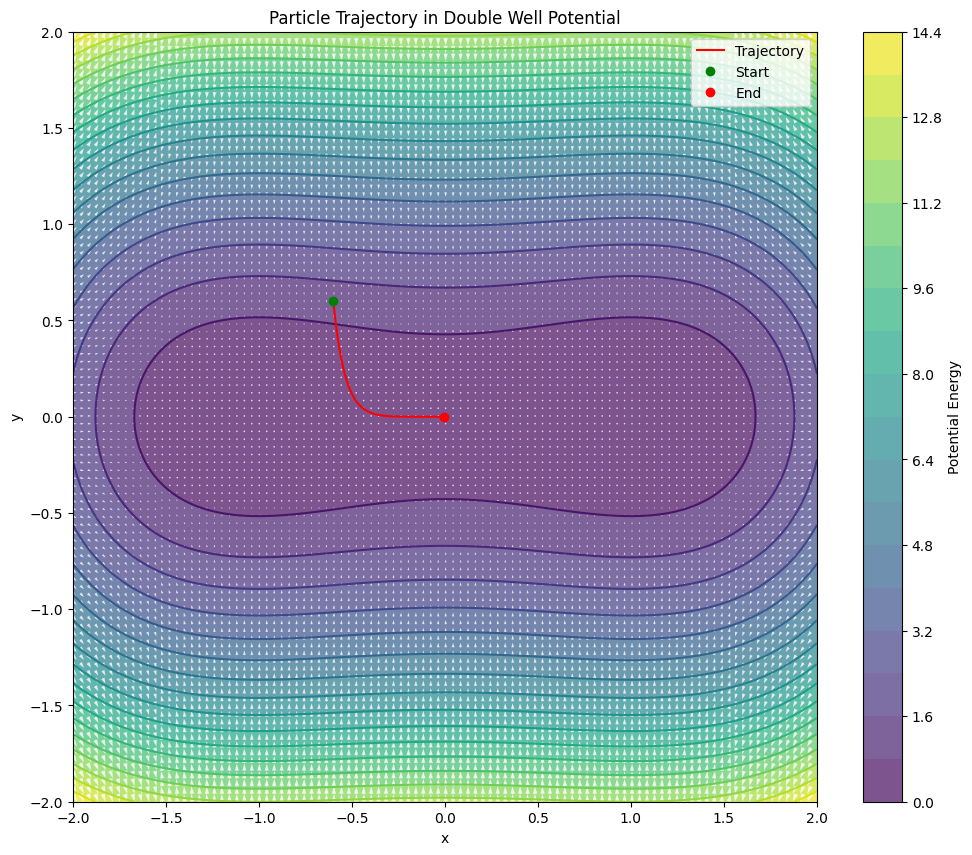

In [39]:

# Define the dynamics
def eigvec_dynamics(state):

    grad_x = grad_V(state)

    H = V_hess(state)
    eig_vals, eig_vecs = jnp.linalg.eigh(H)
    smallest_eigvec = eig_vecs[0]
    
    x_dot = -grad_x + 2 * jnp.dot(grad_x, smallest_eigvec) * smallest_eigvec
    
    return x_dot

eigvec_dynamics = jax.jit(eigvec_dynamics)

# Set up integration
dt = 0.01
T = 500
times = jnp.arange(T) * dt

# Initial conditions
x0 = jnp.array([-0.6, 0.6])  

# Simple Euler integration
def integrate():
    trajectory = [x0]
    state = x0
    
    for _ in range(T-1):
        # Euler step
        state = state + dt * eigvec_dynamics(state)
        trajectory.append(state)
    
    return jnp.array(trajectory)

# Run integration
trajectory = integrate()

eigvec_dynamics_vmap = jax.vmap(eigvec_dynamics)
eigvec_dynamics_grid = eigvec_dynamics_vmap(grid_flat).reshape(N, N, 2)

# Plot results
plt.close()
plt.figure(figsize=(12, 10))

# Plot potential surface
plt.contour(X, Y, Z, levels=20)
plt.contourf(X, Y, Z, levels=20, alpha=0.7)
plt.colorbar(label='Potential Energy')

# Plot trajectory
plt.plot(trajectory[:, 0], trajectory[:, 1], 'r-', label='Trajectory')
plt.plot(trajectory[0, 0], trajectory[0, 1], 'go', label='Start')
plt.plot(trajectory[-1, 0], trajectory[-1, 1], 'ro', label='End')

plt.quiver(X[::skip, ::skip], Y[::skip, ::skip], 
          eigvec_dynamics_grid[::skip, ::skip, 0], eigvec_dynamics_grid[::skip, ::skip, 1],
          color='white', alpha=0.8)

plt.xlabel('x')
plt.ylabel('y')
plt.title('Particle Trajectory in Double Well Potential')
plt.legend()
plt.show()

# Vanilla GAD Potential

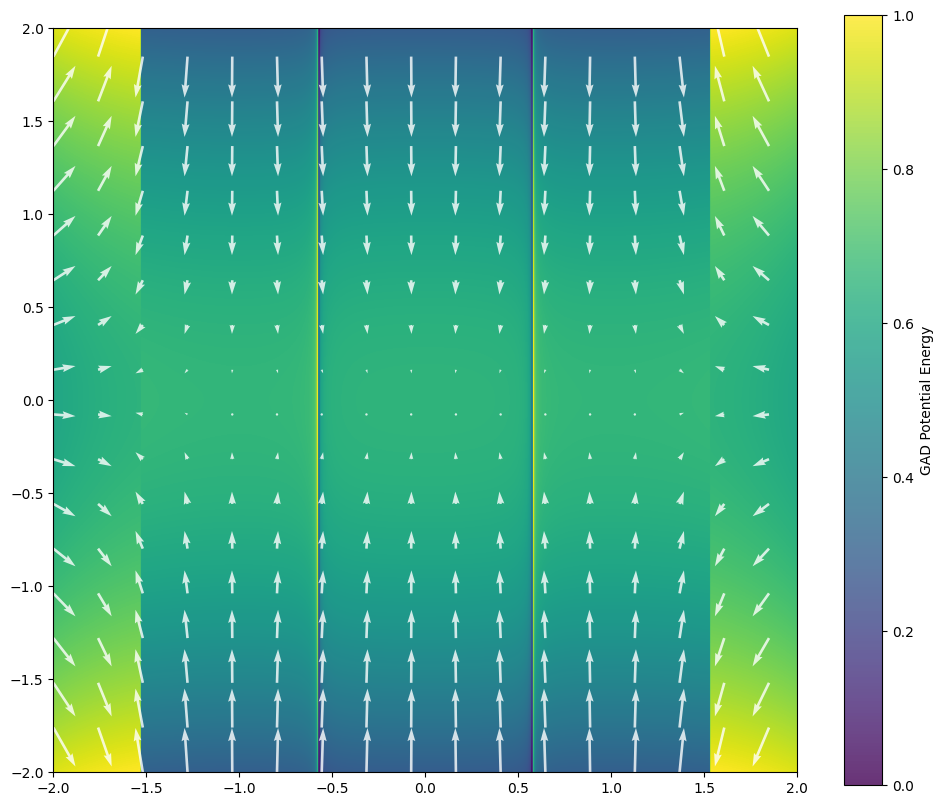

In [40]:
max_allowed_energy = 50.0
def V_GAD(x):
    grad_x = grad_V(x)
    H = V_hess(x)
    eig_vals, eig_vecs = jnp.linalg.eigh(H)
    smallest_eigval = jax.lax.stop_gradient(eig_vals[0])
    smallest_eigvec = jax.lax.stop_gradient(eig_vecs[0])
    second_eigvec = jax.lax.stop_gradient(eig_vecs[1])

    v_gad = -V(x) + 1/smallest_eigval * jnp.dot(grad_x, smallest_eigvec)**2
    # eigval_term = - eig_vals[0] * eig_vals[1]  
    return v_gad

V_GAD_vmap = jax.vmap(V_GAD)
V_GAD_vmap = jax.jit(V_GAD_vmap)
Z = V_GAD_vmap(grid_flat).reshape(N, N)

V_GAD_grad = jax.grad(V_GAD)
V_GAD_grad_vmap = jax.vmap(V_GAD_grad)
V_GAD_grad_grid = V_GAD_grad_vmap(grid_flat).reshape(N, N, 2)


v_dot_fn_vmap = jax.vmap(eigvec_dynamics)
v_dot_grid = v_dot_fn_vmap(grid_flat).reshape(N, N, 2)

# Plot results
plt.close()
plt.figure(figsize=(12, 10))

# Plot potential surface
# plt.contour(X, Y, v_dot_norm, levels=20)
# plt.contourf(X, Y, v_dot_norm, levels=20, alpha=0.7)
skip = 30  # Plot every 5th point for clearer visualization
# Calculate levels based on the data range
# levels = np.linspace(Z.min(), Z.max(), 100)

# Plot potential surface
# plt.contourf(X, Y, Z, levels=100, alpha=0.7)
plt.imshow(
    Z, 
    extent=[X.min(), X.max(), Y.min(), Y.max()],
    origin='lower',  # Put (0,0) at bottom-left
    aspect='equal',  # Make sure x and y scales are equal
    cmap='viridis'  # You can change the colormap if desired
)


plt.quiver(
    X[::skip, ::skip], Y[::skip, ::skip], 
    V_GAD_grad_grid[::skip, ::skip, 0], V_GAD_grad_grid[::skip, ::skip, 1],
    color='white', alpha=0.8
)
plt.colorbar(label='GAD Potential Energy')


plt.show()

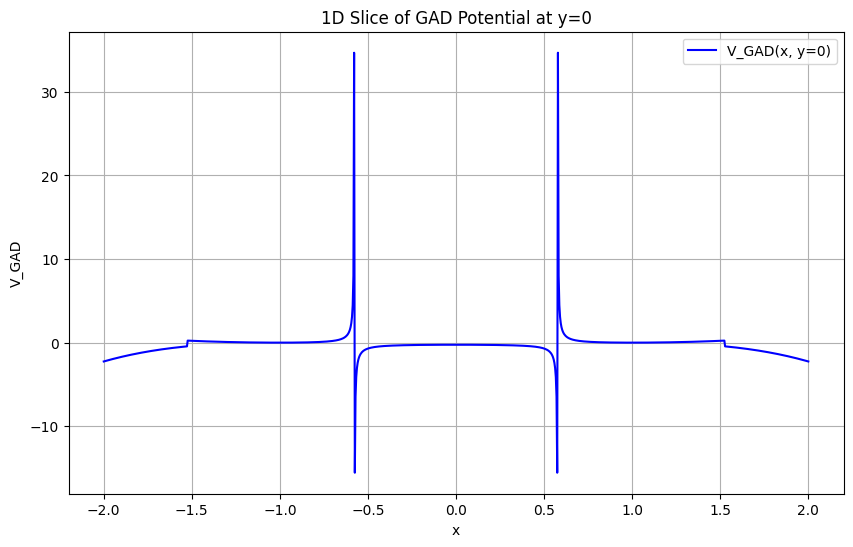

In [41]:
# Create x values for the 1D slice
x_1d = jnp.linspace(-lim, lim, 1000)
# Create points with y = 0
# points = jnp.stack([x_1d, jnp.zeros_like(x_1d) + 1], axis=1)
points = jnp.stack([x_1d, jnp.zeros_like(x_1d)], axis=1)

# Calculate V_GAD values
v_gad_1d = V_GAD_vmap(points)
# v_gad_1d = V_vmap(points)

# Plot the 1D slice
plt.close()
plt.figure(figsize=(10, 6))
plt.plot(x_1d, v_gad_1d, 'b-', label='V_GAD(x, y=0)')
plt.grid(True)
plt.xlabel('x')
plt.ylabel('V_GAD')
plt.title('1D Slice of GAD Potential at y=0')
plt.legend()
# plt.ylim(-10, 10)
plt.show()

# Stitched GAD Potential

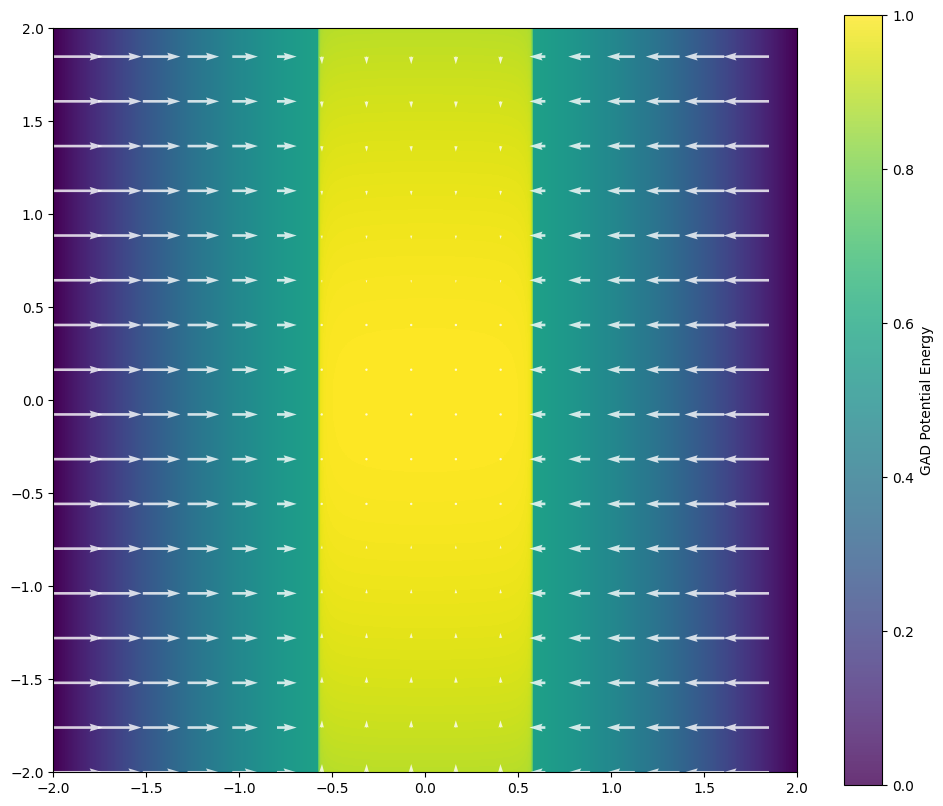

In [42]:
max_allowed_energy = 50.0
def V_GAD(x):
    grad_x = grad_V(x)
    H = V_hess(x)
    eig_vals, eig_vecs = jnp.linalg.eigh(H)
    smallest_eigval = jax.lax.stop_gradient(eig_vals[0])
    smallest_eigvec = jax.lax.stop_gradient(eig_vecs[0])
    second_eigvec = jax.lax.stop_gradient(eig_vecs[1])

    v_gad = jnp.clip(-V(x) + 1/smallest_eigval * jnp.dot(grad_x, smallest_eigvec)**2 + max_allowed_energy,0) 
    eigval_term = - eig_vals[0] * eig_vals[1]  
    return jax.lax.cond(smallest_eigval < 0, lambda: v_gad, lambda: eigval_term) 

V_GAD_vmap = jax.vmap(V_GAD)
V_GAD_vmap = jax.jit(V_GAD_vmap)
Z = V_GAD_vmap(grid_flat).reshape(N, N)

V_GAD_grad = jax.grad(V_GAD)
V_GAD_grad_vmap = jax.vmap(V_GAD_grad)
V_GAD_grad_grid = V_GAD_grad_vmap(grid_flat).reshape(N, N, 2)


v_dot_fn_vmap = jax.vmap(eigvec_dynamics)
v_dot_grid = v_dot_fn_vmap(grid_flat).reshape(N, N, 2)

# Plot results
plt.close()
plt.figure(figsize=(12, 10))

# Plot potential surface
# plt.contour(X, Y, v_dot_norm, levels=20)
# plt.contourf(X, Y, v_dot_norm, levels=20, alpha=0.7)
skip = 30  # Plot every 5th point for clearer visualization
# Calculate levels based on the data range
# levels = np.linspace(Z.min(), Z.max(), 100)

# Plot potential surface
# plt.contourf(X, Y, Z, levels=100, alpha=0.7)
plt.imshow(Z, 
          extent=[X.min(), X.max(), Y.min(), Y.max()],
          origin='lower',  # Put (0,0) at bottom-left
          aspect='equal',  # Make sure x and y scales are equal
          cmap='viridis')  # You can change the colormap if desired



# def eigvecs(x):
#     H = V_hess(x)
#     eig_vals, eig_vecs = jnp.linalg.eigh(H)
#     return eig_vecs
# eigvecs_vmap = jax.vmap(eigvecs)
# eigvecs_grid = eigvecs_vmap(grid_flat).reshape(N, N, 2, 2)
# plt.quiver(X[::skip, ::skip], Y[::skip, ::skip], 
#           eigvecs_grid[::skip, ::skip, 0, 0], eigvecs_grid[::skip, ::skip, 0, 1],
#           color='white', alpha=0.8)
# plt.quiver(X[::skip, ::skip], Y[::skip, ::skip], 
#           eigvecs_grid[::skip, ::skip, 1, 0], eigvecs_grid[::skip, ::skip, 1, 1],
#           color='white', alpha=0.8)
plt.quiver(X[::skip, ::skip], Y[::skip, ::skip], 
          V_GAD_grad_grid[::skip, ::skip, 0], V_GAD_grad_grid[::skip, ::skip, 1],
          color='white', alpha=0.8)
plt.colorbar(label='GAD Potential Energy')

# plt.scatter(centers[:, 0], centers[:, 1], color='black', label='Wells')


plt.show()




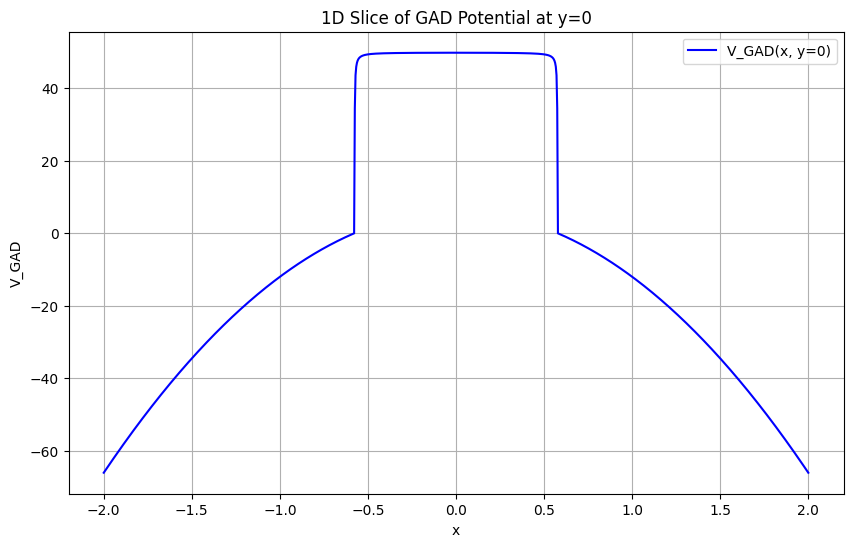

In [43]:
# Create x values for the 1D slice
x_1d = jnp.linspace(-lim, lim, 1000)
# Create points with y = 0
# points = jnp.stack([x_1d, jnp.zeros_like(x_1d) + 1], axis=1)
points = jnp.stack([x_1d, jnp.zeros_like(x_1d)], axis=1)

# Calculate V_GAD values
v_gad_1d = V_GAD_vmap(points)
# v_gad_1d = V_vmap(points)

# Plot the 1D slice
plt.close()
plt.figure(figsize=(10, 6))
plt.plot(x_1d, v_gad_1d, 'b-', label='V_GAD(x, y=0)')
plt.grid(True)
plt.xlabel('x')
plt.ylabel('V_GAD')
plt.title('1D Slice of GAD Potential at y=0')
plt.legend()
# plt.ylim(-10, 10)
plt.show()

In [44]:
V([0.0,0.0])

Array(0.25, dtype=float32, weak_type=True)

## GAD without stop gradients

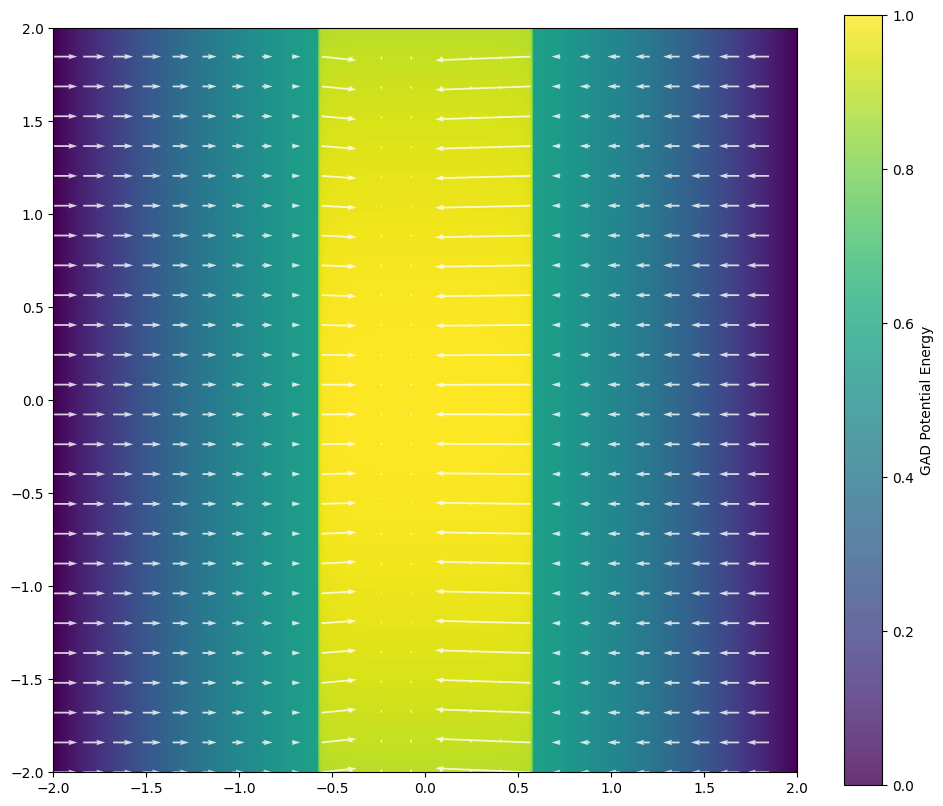

In [50]:
max_allowed_energy = 50.0
def V_GAD(x):
    grad_x = grad_V(x)
    H = V_hess(x)
    eig_vals, eig_vecs = jnp.linalg.eigh(H)
    smallest_eigval = eig_vals[0]
    smallest_eigvec = eig_vecs[0]
    second_eigvec = eig_vecs[1]

    v_gad = jnp.clip(-V(x) + 1/(smallest_eigval + 1e-6) * jnp.dot(grad_x, smallest_eigvec)**2 + max_allowed_energy,0) 
    eigval_term = - eig_vals[0] * eig_vals[1]  
    return jax.lax.cond(smallest_eigval < 0, lambda: v_gad, lambda: eigval_term) 

V_GAD_vmap = jax.vmap(V_GAD)
V_GAD_vmap = jax.jit(V_GAD_vmap)
Z = V_GAD_vmap(grid_flat).reshape(N, N)

V_GAD_grad = jax.grad(V_GAD)
V_GAD_grad_vmap = jax.vmap(V_GAD_grad)
V_GAD_grad_grid = V_GAD_grad_vmap(grid_flat).reshape(N, N, 2)


v_dot_fn_vmap = jax.vmap(eigvec_dynamics)
v_dot_grid = v_dot_fn_vmap(grid_flat).reshape(N, N, 2)

# Plot results
plt.figure(figsize=(12, 10))

# Plot potential surface
# plt.contour(X, Y, v_dot_norm, levels=20)
# plt.contourf(X, Y, v_dot_norm, levels=20, alpha=0.7)
skip = 20  # Plot every 5th point for clearer visualization
# Calculate levels based on the data range
# levels = np.linspace(Z.min(), Z.max(), 100)

# Plot potential surface
# plt.contourf(X, Y, Z, levels=100, alpha=0.7)
plt.imshow(
    Z, 
    extent=[X.min(), X.max(), Y.min(), Y.max()],
    origin='lower',  # Put (0,0) at bottom-left
    aspect='equal',  # Make sure x and y scales are equal
    cmap='viridis'  # You can change the colormap if desired
)

plt.quiver(
    X[::skip, ::skip], Y[::skip, ::skip], 
    V_GAD_grad_grid[::skip, ::skip, 0], V_GAD_grad_grid[::skip, ::skip, 1],
    color='white', alpha=0.8
)
plt.colorbar(label='GAD Potential Energy')

# plt.scatter(centers[:, 0], centers[:, 1], color='black', label='Wells')


plt.show()